In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #normalisation
from sklearn.metrics import accuracy_score #scoring
import seaborn as sns

In [13]:
# leitura de dados BankNote
data_file = "../dataset/sample-data/banknote.xlsx"

# Read the Excel file using pandas
df = pd.read_excel(data_file)

In [27]:
df.info()

print("\n")

print("Shape: \n", df.shape)

print("\n")

print("Columns: \n", df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


Shape: 
 (1372, 5)


Columns: 
 Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')


In [14]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


In [15]:
print("Column names:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Column names: ['variance', 'skewness', 'curtosis', 'entropy', 'class']

First 5 rows:


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [16]:
((df.drop("class", axis=1)) == 0).sum()

variance    0
skewness    0
curtosis    0
entropy     0
dtype: int64

<Axes: xlabel='class'>

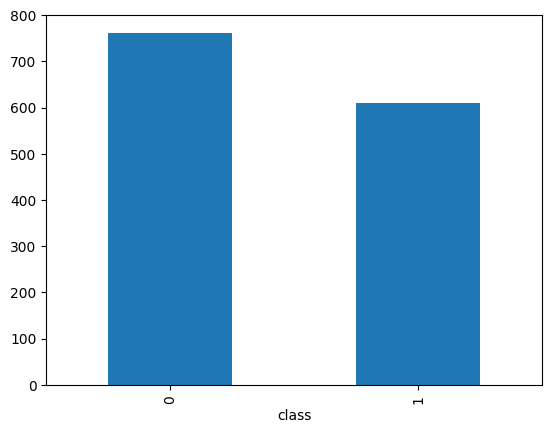

In [17]:
df["class"].value_counts().plot(kind="bar")

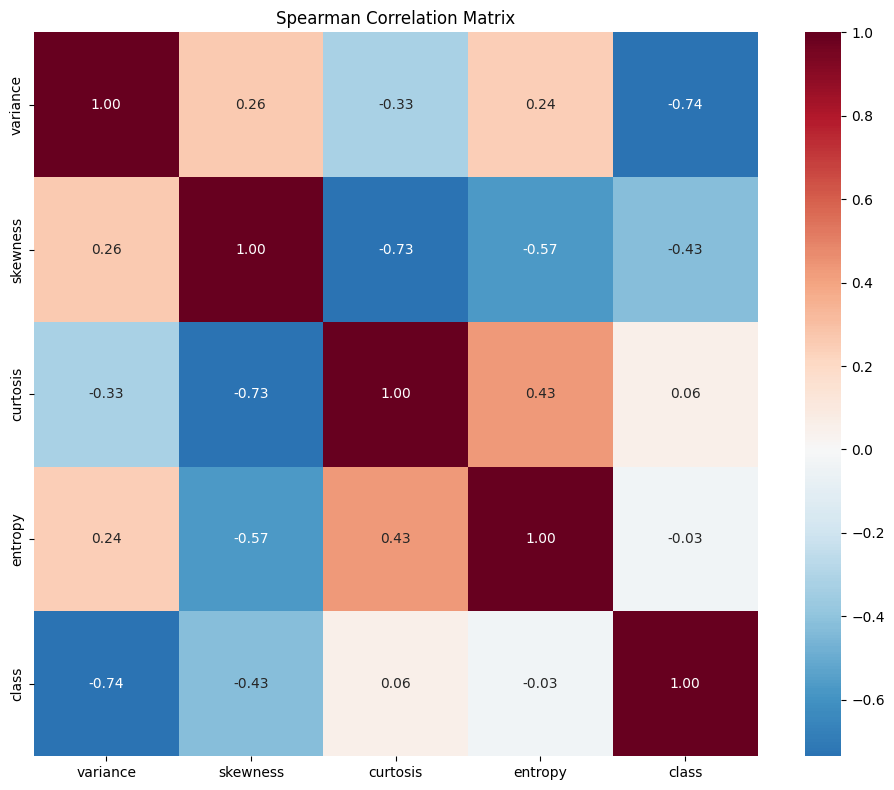

In [30]:
corr_spearman = df.corr(method="spearman")

# Improve the correlation plot
plt.figure(figsize=(10, 8))
# mask = np.triu(np.ones_like(corr_spearman, dtype=bool))  # Show only lower triangle
sns.heatmap(
    corr_spearman,
    #    mask=mask,
    annot=True,
    cmap="RdBu_r",  # Better color scheme
    center=0,  # Center colormap at 0
    square=True,  # Square cells
    fmt=".2f",
)  # Two decimal places
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()



# Correlation Analysis Interpretation

Based on the Spearman correlation matrix above, here's what each correlation tells us:

## Strong Correlations (|r| > 0.7):
- **Skewness ↔ Curtosis: -0.73** (Strong Negative)
  - When skewness increases, kurtosis tends to decrease significantly
  - This suggests these two shape parameters of the distribution are inversely related

## Moderate Correlations (0.3 < |r| < 0.7):
- **Variance ↔ Curtosis: -0.33** (Moderate Negative)
  - Higher variance tends to correspond with lower kurtosis
- **Skewness ↔ Entropy: -0.57** (Moderate Negative)  
  - Higher skewness corresponds with lower entropy (less randomness)
- **Curtosis ↔ Entropy: 0.43** (Moderate Positive)
  - Higher kurtosis corresponds with higher entropy (more randomness)

## Weak Correlations (|r| < 0.3):
- **Variance ↔ Skewness: 0.26** (Weak Positive)
- **Variance ↔ Entropy: 0.24** (Weak Positive)

## Key Insights:
1. **Skewness and Curtosis** have the strongest relationship - they move in opposite directions
2. **Entropy** seems to be moderately related to the shape parameters (skewness and curtosis)
3. **Variance** is relatively independent from other features
4. No perfect correlations exist, so all features provide some unique information

In [31]:
# Better approaches for analyzing relationship with categorical target

# 1. Point-biserial correlation (for binary categorical vs continuous)
from scipy.stats import pointbiserialr

print("Point-biserial correlations (more appropriate for binary target):")
print("="*60)
for col in df.columns[:-1]:  # All except 'class'
    corr, p_value = pointbiserialr(df['class'], df[col])
    print(f"{col}: r = {corr:.3f}, p-value = {p_value:.3f}")

# 2. Group statistics comparison
print("\n" + "="*60)
print("Feature statistics by class:")
print("="*60)
feature_stats = df.groupby('class').agg(['mean', 'std', 'median'])
print(feature_stats)

# 3. Effect size (Cohen's d) for each feature
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * group1.var() + (n2 - 1) * group2.var()) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_std

print("\n" + "="*60)
print("Effect sizes (Cohen's d) - measures practical significance:")
print("="*60)
authentic = df[df['class'] == 0]
counterfeit = df[df['class'] == 1]

for col in df.columns[:-1]:
    d = cohens_d(authentic[col], counterfeit[col])
    effect_size = "Large" if abs(d) > 0.8 else "Medium" if abs(d) > 0.5 else "Small"
    print(f"{col}: d = {d:.3f} ({effect_size} effect)")

Point-biserial correlations (more appropriate for binary target):
variance: r = -0.725, p-value = 0.000
skewness: r = -0.445, p-value = 0.000
curtosis: r = 0.156, p-value = 0.000
entropy: r = -0.023, p-value = 0.386

Feature statistics by class:
       variance                    skewness                      curtosis  \
           mean       std  median      mean       std    median      mean   
class                                                                       
0      2.276686  2.019348  2.5531  4.256627  5.138792  5.668800  0.796718   
1     -1.868443  1.881183 -1.8061 -0.993576  5.404884  0.172775  2.148271   

                            entropy                     
            std    median      mean       std   median  
class                                                   
0      3.239894  0.700605 -1.147640  2.125077 -0.55238  
1      5.261811  0.373720 -1.246641  2.070984 -0.66165  

Effect sizes (Cohen's d) - measures practical significance:
variance: d = 2.116 (L

In [32]:
# Statistical significance tests
from scipy.stats import mannwhitneyu, ttest_ind

print("Statistical tests for group differences:")
print("="*50)

for col in df.columns[:-1]:
    group_0 = df[df['class'] == 0][col]
    group_1 = df[df['class'] == 1][col]
    
    # Mann-Whitney U test (non-parametric)
    statistic, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')
    
    print(f"\n{col}:")
    print(f"  Mann-Whitney U p-value: {p_value:.6f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

Statistical tests for group differences:

variance:
  Mann-Whitney U p-value: 0.000000
  Significant difference: Yes

skewness:
  Mann-Whitney U p-value: 0.000000
  Significant difference: Yes

curtosis:
  Mann-Whitney U p-value: 0.022561
  Significant difference: Yes

entropy:
  Mann-Whitney U p-value: 0.225288
  Significant difference: No


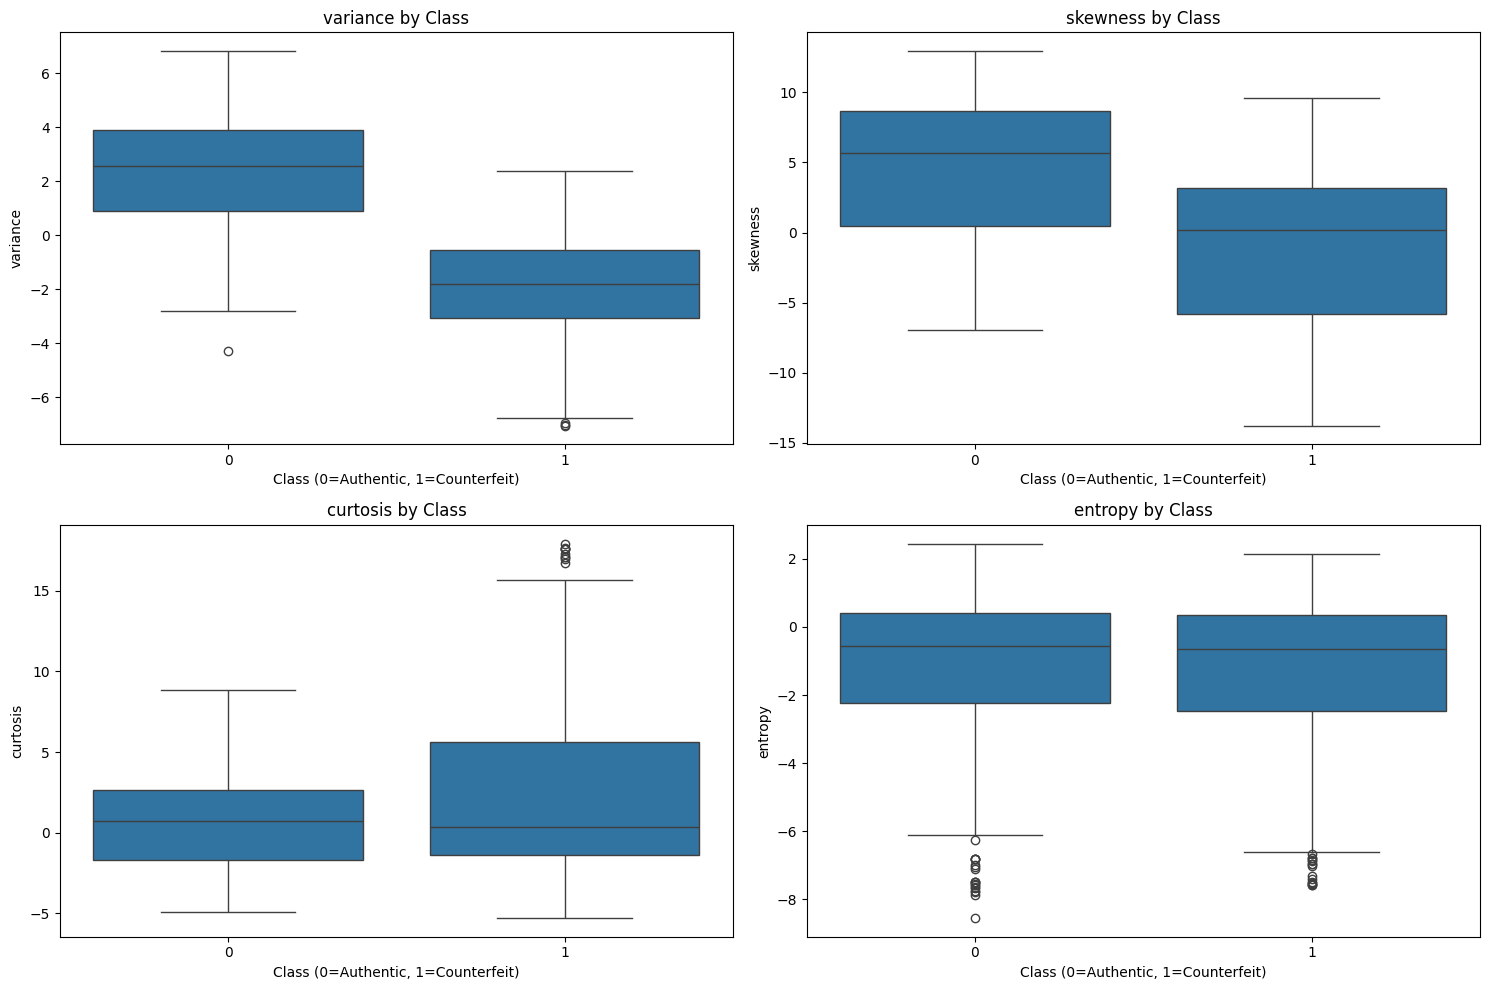

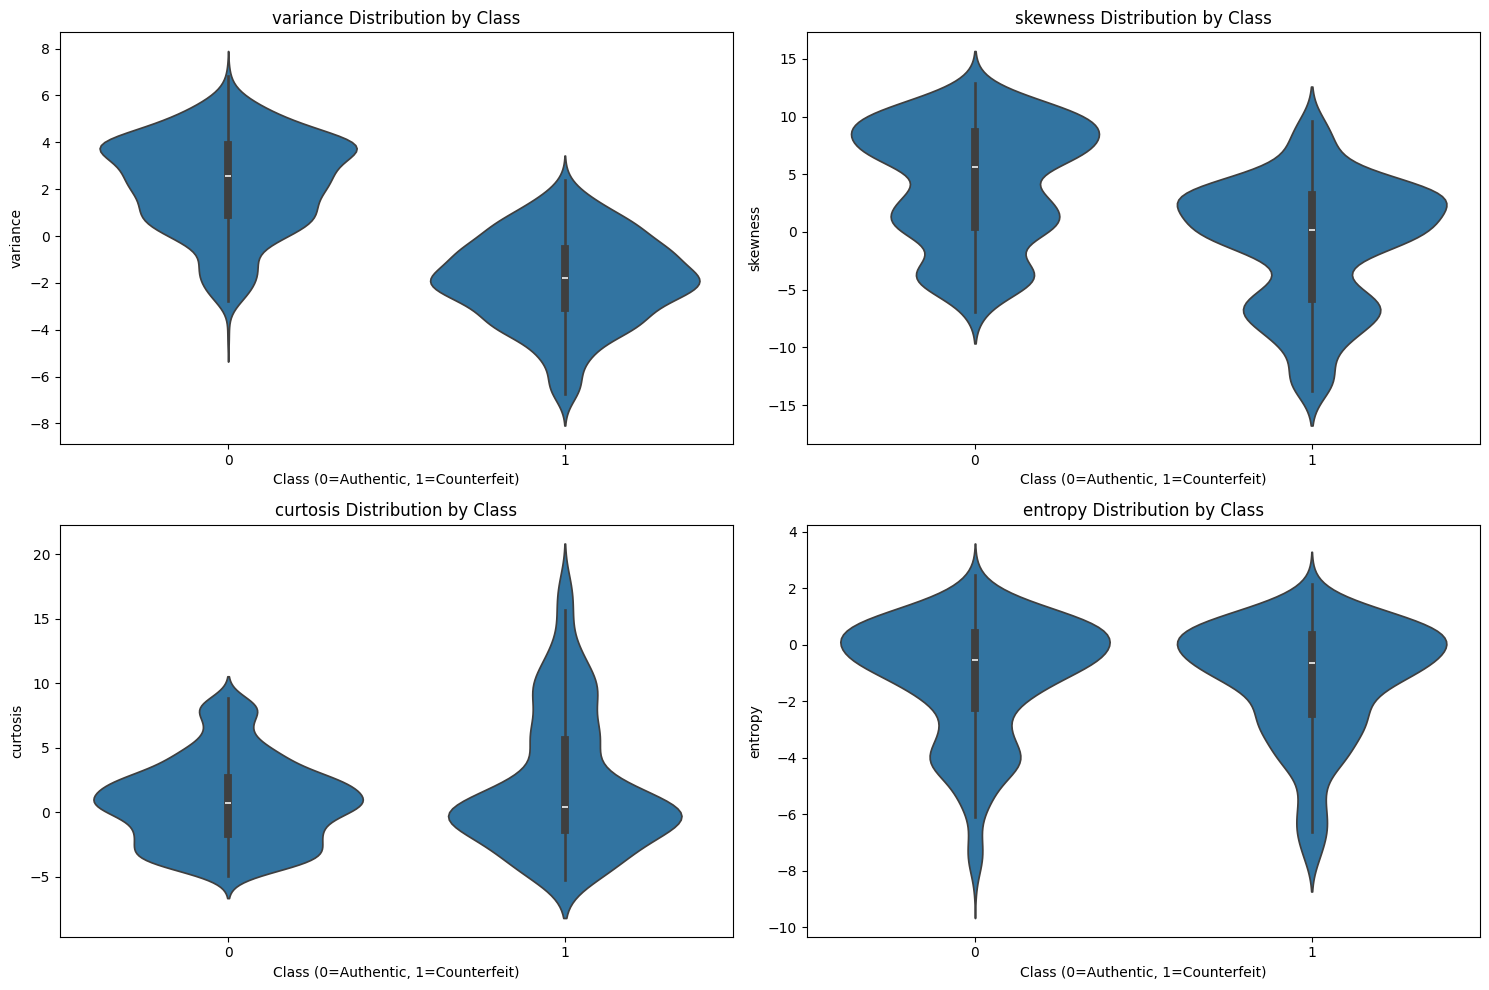

In [34]:
# Better visualizations for categorical vs continuous analysis

# Box plots showing distribution differences
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(data=df, x='class', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Class')
    axes[i].set_xlabel('Class (0=Authentic, 1=Counterfeit)')

plt.tight_layout()
plt.show()

# Violin plots for distribution shape comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(df.columns[:-1]):
    sns.violinplot(data=df, x='class', y=col, ax=axes[i])
    axes[i].set_title(f'{col} Distribution by Class')
    axes[i].set_xlabel('Class (0=Authentic, 1=Counterfeit)')

plt.tight_layout()
plt.show()

In [19]:
# Extract data into NumPy arrays
X = df.iloc[:, :-1].values # Features (all columns except the last one)
y = df.iloc[:, -1].values  # Labels (the last column)

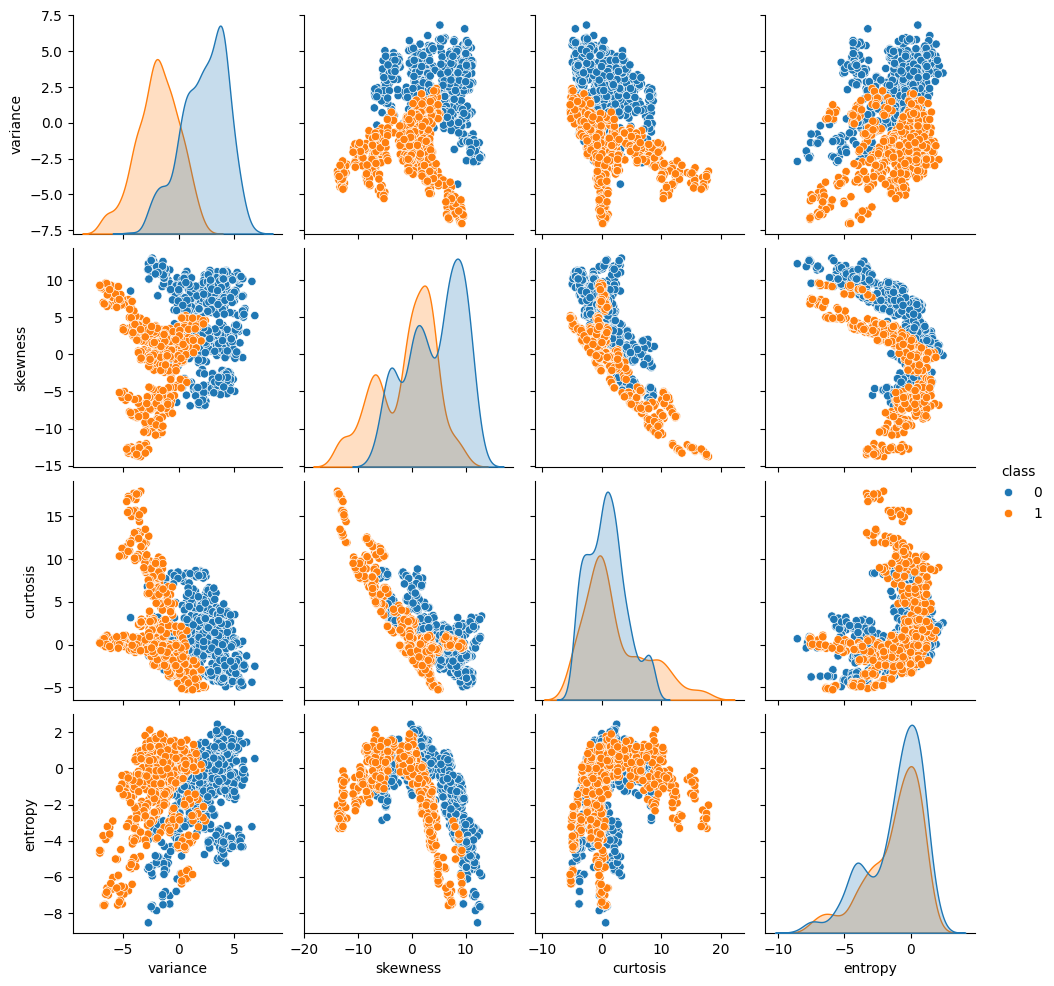

In [23]:
sns.pairplot(df, hue="class")

<Axes: >

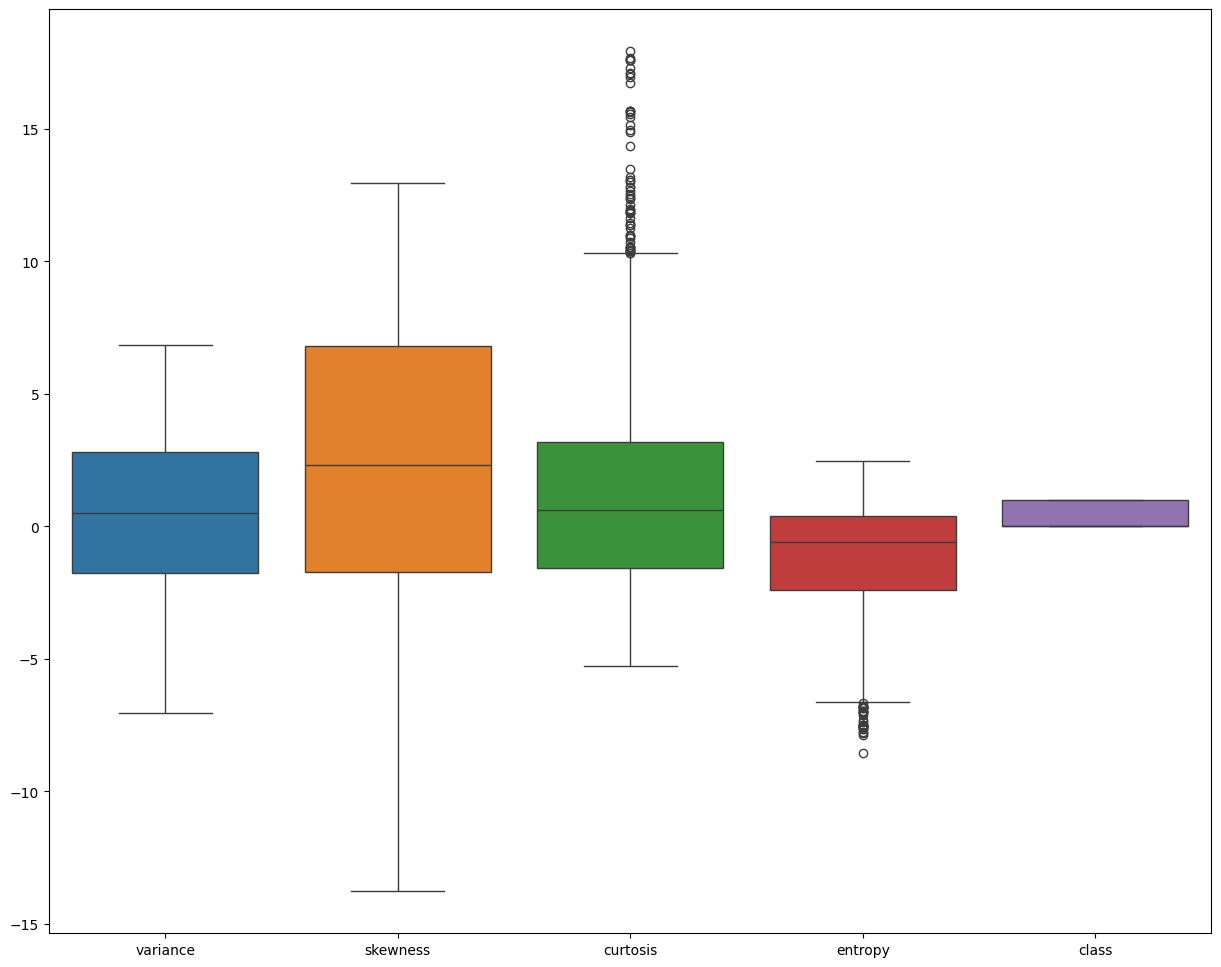

In [24]:
plt.figure(figsize=(15, 12))
sns.boxplot(data=df)

In [25]:
print(df.duplicated().sum())

24
